In [12]:
#!pip install darts

1. Análisis Exploratorio:
Describir la serie de tiempo y visualizarla.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, Theta, RNNModel
from darts.metrics import mae, rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

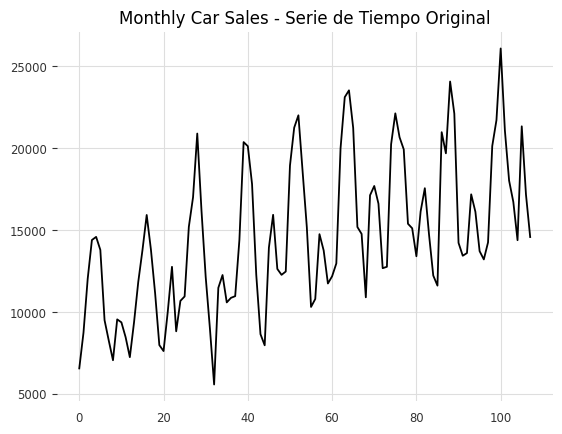

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame desde el archivo CSV
dataset = pd.read_csv('./monthly-car-sales.csv')

# Acceder a la columna 'Sales'
value_column = dataset['Sales']

# Graficar la serie de tiempo
plt.plot(value_column)
plt.title("Monthly Car Sales - Serie de Tiempo Original")
plt.show()


2. Promedios:

- Aplicar métodos de promedios y comparar los resultados con el conjunto original

In [15]:
def promedio_movil(series, window_size):
    return series.rolling(window=window_size).mean()

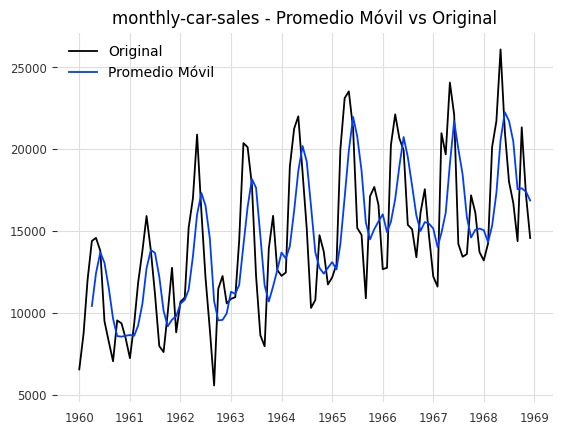

In [16]:
config = {
    'time': 'Month',    
    'value': 'Sales'  
}

# Crear la serie temporal 'series'
series = TimeSeries.from_dataframe(dataset, config['time'], config['value'])

# Calcular el promedio móvil
ma_series = promedio_movil(series.pd_dataframe()[config['value']], window_size=4)

# Graficar la serie original y el promedio móvil
plt.plot(series.pd_dataframe()[config['value']], label='Original')
plt.plot(ma_series, label='Promedio Móvil')
plt.legend()
plt.title("monthly-car-sales - Promedio Móvil vs Original")
plt.show()

3. SARIMA:
- Identificar parámetros y ajustar un modelo SARIMA

In [17]:
train, val = series.split_after(0.8)
# orden estacional
if len(train) >= 50: 
    seasonal_order = (1, 1, 1, 12)
else:
    seasonal_order = (0, 0, 0, 0)

sarima = SARIMAX(train.pd_dataframe(), order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_fitted = sarima.fit()
sarima_forecast = sarima_fitted.get_forecast(steps=len(val)).predicted_mean
sarima_forecast_series = TimeSeries.from_series(pd.Series(sarima_forecast, index=val.pd_dataframe().index))
print(f"SARIMA - RMSE: {rmse(val, sarima_forecast_series)}")
print(f"SARIMA - MAE: {mae(val, sarima_forecast_series)}")

SARIMA - RMSE: 1865.423075815929
SARIMA - MAE: 1526.204615071135


4. Alisamiento Exponencial:
- Aplicar diferentes métodos de alisamiento exponencial y comparar.

In [18]:
exp_model = ExponentialSmoothing()
exp_model.fit(train)
exp_forecast = exp_model.predict(len(val))
print(f"Exponential Smoothing - RMSE: {rmse(val, exp_forecast)}")
print(f"Exponential Smoothing - MAE: {mae(val, exp_forecast)}")

Exponential Smoothing - RMSE: 2023.111906546764
Exponential Smoothing - MAE: 1564.5186137987794


c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


5. Prophet:
- Utilizar Prophet para modelar la serie de tiempo.

In [19]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_forecast = prophet_model.predict(len(val))
print(f"Prophet - RMSE: {rmse(val, prophet_forecast)}")
print(f"Prophet - MAE: {mae(val, prophet_forecast)}")

10:41:02 - cmdstanpy - INFO - Chain [1] start processing
10:41:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 1824.6876324950135
Prophet - MAE: 1491.826440360253


6. Redes Neuronales:
- Implementar una red neuronal simple para prever la serie de tiempo

In [20]:
rnn_model = RNNModel(model='LSTM', input_chunk_length=12, output_chunk_length=1, n_epochs=200)
rnn_model.fit(train)
rnn_forecast = rnn_model.predict(len(val))
print(f"RNN - RMSE: {rmse(val, rnn_forecast)}")
print(f"RNN - MAE: {mae(val, rnn_forecast)}")

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

RNN - RMSE: 18294.15947327763
RNN - MAE: 17903.185811810858


7. Comparación y Evaluación:
- Usar métricas como RMSE, MAE para comparar los modelos.

In [21]:
metrics = {}
metrics['SARIMA'] = [rmse(val, sarima_forecast_series), mae(val, sarima_forecast_series)]
metrics['Exponential'] = [rmse(val, exp_forecast), mae(val, exp_forecast)]
metrics['Prophet'] = [rmse(val, prophet_forecast), mae(val, prophet_forecast)]
metrics['RNN'] = [rmse(val, rnn_forecast), mae(val, rnn_forecast)]

In [22]:
best_rmse_model = min(metrics, key=lambda k: metrics[k][0])
best_mae_model = min(metrics, key=lambda k: metrics[k][1])

print(f"El mejor modelo por RMSE es: {best_rmse_model} con un valor de {metrics[best_rmse_model][0]}")
print(f"El mejor modelo por MAE es: {best_mae_model} con un valor de {metrics[best_mae_model][1]}")

El mejor modelo por RMSE es: Prophet con un valor de 1824.6876324950135
El mejor modelo por MAE es: Prophet con un valor de 1491.826440360253
